In [ ]:
!pip install -q keras-ocr

In [ ]:
%%capture
!gdown --id '1mOMS71hXclgOWmRZ8O18HCTum3kzERZ5'
!gdown --id '1R2SY1LNK1i4G1Mg-EYXyn4Ep__l91C9z'
!gdown --id '1LFN1BD1fFN9vkFxACCuFFOZS1VHiRpTW'
!gdown --id '1-3KXdRBLJGT-ZESZPdHmqUCTHOJzvbeT'

In [ ]:
%%capture
from zipfile import ZipFile
files = ['license_plates_detection_train.zip', 'test.zip']
parent_dir = "dataset/"

for file_name in files:
  zf = ZipFile(file_name, 'r')
  zf.extractall(parent_dir)
  zf.close()

In [ ]:
%%capture
! mkdir dataset/train_data
! mkdir dataset/test_data
! mv -v /content/dataset/license_plates_detection_train/* /content/dataset/train_data
! mv -v /content/dataset/test_private/* /content/dataset/test_data
! rm -r /content/dataset/license_plates_detection_train /content/dataset/test_private/
! mv license_plates_detection_train.csv dataset/train_target.csv
! rm license_plates_detection_train.zip test.zip

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import tensorflow as tf
import pandas as pd
import cv2
import os

# import the necessary packages
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from sklearn.model_selection import train_test_split
from google.colab.patches import cv2_imshow


In [ ]:
BASE_PATH = "dataset"
IMAGES_PATH = os.path.sep.join([BASE_PATH, "train_data"])
LEBELS_PATH = os.path.sep.join([BASE_PATH, "train_target.csv"])
TEST_IMAGES_PATH = os.path.sep.join([BASE_PATH, "test_data/"])
CROPPED_IMAGES_PATH = os.path.sep.join([BASE_PATH, "cropped_license/"])

BASE_OUTPUT = "output"
MODEL_PATH = os.path.sep.join([BASE_OUTPUT, "detector.h5"])
PLOT_PATH = os.path.sep.join([BASE_OUTPUT, "plot.png"])

# initialize our initial learning rate, number of epochs to train
# for, and the batch size
INIT_LR = 1e-4
NUM_EPOCHS = 250
BATCH_SIZE = 10

#Explore the dateset

In [ ]:
df = pd.read_csv(LEBELS_PATH)
df.head()

In [ ]:
row = df.loc[[400]]
frame = cv2.imread(os.path.join(IMAGES_PATH,row['img_id'].item()))
xmin, ymin = row['xmin'].item(), row['ymin'].item()
xmax, ymax = row['xmax'].item(), row['ymax'].item()

p_frame = cv2.rectangle(frame, (xmin, ymin), (xmax, ymax), (0,0,255), 1)
p_frame = cv2.circle(p_frame,(xmin,ymin),5,(0,0,255),-1)
p_frame = cv2.circle(p_frame,(xmax,ymax),5,(0,0,255),-1)
cv2_imshow(p_frame)
print(p_frame.shape)

In [ ]:
(h, w) = (p_frame.shape[:2])
targetSize= 224
print(f'width: {w}, height:{h}')
print(f'xmin:{xmin},ymin:{ymin}, xmax:{xmax}, ymax:{ymax}')

x_scale = targetSize / w
y_scale = targetSize / h
print(f'x_scale: {x_scale}, y_scale:{y_scale}')

resized_xmin = xmin / w
resized_ymin = ymin / h
resized_xmax = xmax / w
resized_ymax = ymax / h

print(f'new width: {targetSize}, new height:{targetSize}')
print(f'resized_xmin:{resized_xmin},resized_ymin:{resized_ymin}, resized_xmax:{resized_xmax}, resized_ymax:{resized_ymax}')

resized_xmin = int(np.round(resized_xmin*targetSize))
resized_ymin = int(np.round(resized_ymin*targetSize))
resized_xmax = int(np.round(resized_xmax*targetSize))
resized_ymax = int(np.round(resized_ymax*targetSize))

img = cv2.imread(os.path.join(IMAGES_PATH,row['img_id'].item()))

resized_img = cv2.resize(img, (targetSize, targetSize));
resized_img = cv2.rectangle(resized_img, (resized_xmin, resized_ymin), (resized_xmax, resized_ymax), (0,0,255), 1)
cv2_imshow(resized_img)

# Creating the Training and validation loaders

In [ ]:
print("Creating the Training and validation loaders ...")

data = []
targets = []
filenames = []

for index, row in df.iterrows():
  filename = row['img_id']
  xmin, ymin = row['xmin'], row['ymin']
  xmax, ymax = row['xmax'], row['ymax']
  
  imagePath = os.path.sep.join([IMAGES_PATH, filename])
  image = cv2.imread(imagePath)
  (h, w) = (image.shape[:2])

  resized_xmin = xmin / w
  resized_ymin = ymin / h
  resized_xmax = xmax / w
  resized_ymax = ymax / h

  image = load_img(imagePath, target_size=(224, 224))
  image = img_to_array(image)

  data.append(image)
  targets.append((resized_xmin, resized_ymin, resized_xmax, resized_ymax))
  filenames.append(filename)

data = np.array(data, dtype="float32") / 255.0
targets = np.array(targets, dtype="float32")

split = train_test_split(data, targets, filenames, test_size=0.20,
    random_state=123)

(trainImages, testImages) = split[:2]
(trainTargets, testTargets) = split[2:4]
(trainFilenames, testFilenames) = split[4:]

#Model creation and training

In [ ]:
from numpy.core.numeric import True_

resnet50 = ResNet50(include_top=False, weights='imagenet', input_tensor=Input(shape=(224, 224, 3)))
resnet50.trainable = True

flatten = resnet50.output
flatten = Flatten()(flatten)

bboxHead = Dense(512, activation="relu")(flatten)
bboxHead = Dense(128, activation="relu")(bboxHead)
bboxHead = Dense(32, activation="relu")(bboxHead)
bboxHead = Dense(4, activation="sigmoid")(bboxHead)

model = Model(inputs=resnet50.input, outputs=bboxHead)


In [ ]:
opt = Adam(lr=INIT_LR)
model.compile(loss="mse", optimizer=opt)
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=50, verbose=1,
    mode='auto', baseline=None, restore_best_weights=True
)
print(model.summary())

print("[INFO] training bounding box regressor...")
with tf.device('/device:GPU:0'):
	H = model.fit(
		trainImages, trainTargets,
		validation_data=(testImages, testTargets),
		batch_size=BATCH_SIZE,
		epochs=NUM_EPOCHS,
		callbacks=[callback],
		verbose=1)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

# Saving the model checkpoint and visualizing the training metrics

[INFO] saving object detector model...


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


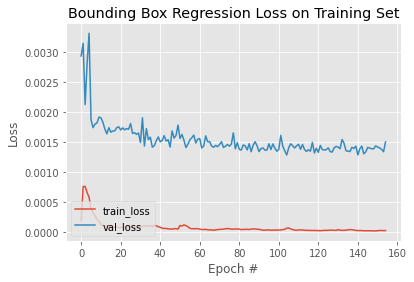

In [ ]:
# serialize the model to disk
print("[INFO] saving object detector model...")
model.save(MODEL_PATH, save_format="h5")
# plot the model training history
N = 155
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.title("Bounding Box Regression Loss on Training Set")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.savefig(PLOT_PATH)

#Testing the model performance with the test data and extracting the licenses from the images

In [ ]:
imagePaths = []
for f in os.listdir(TEST_IMAGES_PATH):
  abspath = TEST_IMAGES_PATH + f
  imagePaths.append(abspath)

In [ ]:

print("[INFO] loading object detector...")
model = load_model('/content/detector.h5')

target_size = 224
if not os.path.exists(CROPPED_IMAGES_PATH):
    os.makedirs(CROPPED_IMAGES_PATH)

for count, imagePath in enumerate(imagePaths):

    img_name = os.path.basename(imagePath)
    image = load_img(imagePath, target_size=(224, 224))
    image = img_to_array(image) / 255.0
    image = np.expand_dims(image, axis=0)

    preds = model.predict(image)[0]
    (startX, startY, endX, endY) = preds

    image = cv2.imread(imagePath)
    image = imutils.resize(image, width=600)
    (h, w) = image.shape[:2]

    xmin = int(np.round(startX*w))
    ymin = int(np.round(startY*h))
    xmax = int(np.round(endX*w))
    ymax = int(np.round(endY*h))    
    #draw the predicted bounding box on the image
    cv2.rectangle(image, (xmin, ymin), (xmax, ymax),
        (0, 255, 0), 2)
    #Crop the license plates from the orginal images.    
    cropped_lp = image[ymin:ymax, xmin:xmax, :]
    # save cropped_image
    img_name = "cropped_"+img_name
    cv2.imwrite(os.path.join(CROPPED_IMAGES_PATH, img_name), cropped_lp)
    if(count<5):
      # show the output image
      cv2_imshow(image)
      cv2.waitKey(0)

#Licence plate recognition on the cropped licenses using Keras Optical Characters Recognition

In [ ]:
crop_imagePaths = []
for f in os.listdir(CROPPED_IMAGES_PATH):
  abspath = CROPPED_IMAGES_PATH + f
  crop_imagePaths.append(abspath)

In [ ]:
import keras_ocr
import matplotlib.pyplot as plt

pipeline = keras_ocr.pipeline.Pipeline()

images = [
   keras_ocr.tools.read(img_abspath) for img_abspath in crop_imagePaths
]


Looking for /root/.keras-ocr/craft_mlt_25k.h5
Looking for /root/.keras-ocr/crnn_kurapan.h5


In [ ]:
prediction_groups = pipeline.recognize(images)

In [ ]:
for image, predictions, img_abspath in zip(images, prediction_groups, crop_imagePaths):
    npl = list()
    license_plate = ''
    for p in predictions:
      if (p[0].isdecimal()):
        npl.append(p[0])
      else:
        continue 
    for n in npl:
      license_plate += n
      license_plate += ' '
    print(img_abspath)
    print(f'License plate: {license_plate}') 